In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv, concat
from arviz import hdi
sns.set_theme(style='ticks', context='notebook', font_scale=1.2)

## Section 1: Model Diagnostics

In [2]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3']

### 1.1 Stan diagnostics


In [3]:
## Main loop.
diagnostics = []
for m in models:
    
    for s in sessions:

        ## Load Stan summary.
        samples = read_csv(os.path.join('stan_results', s, f'{m}.tsv.gz'), sep='\t', compression='gzip')
        summary = read_csv(os.path.join('stan_results', s, f'{m}_summary.tsv'), sep='\t', index_col=0)
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Apply restrictions.
        ppc = ppc[~np.isinf(ppc.k_u)]                        # Removed fixed parameters.

        ## Identify number of divergences.
        divergence = samples.divergent__.sum()

        ## Identify parameters failing to reach convergence.
        rhat = len(summary.query('R_hat >= 1.02'))

        ## Identify parameters with low effective sample size.
        n_eff = len(summary.query('N_Eff < 400'))

        ## Identify number of effective parameters.
        p_loo = ppc.pwaic.sum()

        ## Identify number of poorly predicted observations.
        pk = np.sum(ppc.k_u > 0.7)

        ## Convert to dictionary. Append.
        diagnostics.append(dict(
            model = m,
            session = s,
            divergence = divergence,
            rhat = rhat,
            n_eff = n_eff,
            p_loo = np.round(p_loo, 1),
            pk = np.round(pk, 3)
        ))

## Convert to DataFrame.
diagnostics = DataFrame(diagnostics).sort_values(['session','model']).set_index(['session','model'])
diagnostics

divergence  rhat  n_eff  p_loo  pk
session model                                      
s1      pgng_m1         0.0     0      0   31.0  16
        pgng_m2         0.0     0      1   48.5   0
        pgng_m3         0.0     0      0   63.9   0
        pgng_m4         0.0     0      0   75.5   0
        pgng_m5         0.0     0      0   74.7   0
        pgng_m6         0.0     0      0   80.9   0
        pgng_m7         0.0     0      0   93.4   0
s2      pgng_m1         0.0     0      0   23.2  16
        pgng_m2         0.0     1      1   40.1   0
        pgng_m3         0.0     1      0   54.0   0
        pgng_m4         0.0     0      0   63.5   0
        pgng_m5         0.0     0      0   60.8   0
        pgng_m6         0.0     0      0   67.7   0
        pgng_m7         0.0     0      0   80.7   0
s3      pgng_m1         0.0     0      0   23.6  24
        pgng_m2         0.0     0      0   41.4   0
        pgng_m3         0.0     0      0   56.1   0
        pgng_m4         0.0     0      0   63.9   0
        pgng_m5         0.0     0      0   62.4   0
        pgng_m6         0.0     0      0   69.6   0
        pgng_m7         0.0     0      0   82.2   0

## Section 2: Model Comparison

In [4]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3']

### 2.1 LOO-CV indices

In [5]:
## Main loop.
loocv = []
for m in models:

    for s in sessions:
    
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute LOO-CV.
        loo = -2 * ppc.loo.sum()

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, loocv=loo))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'session', 'model')
loocv.round(1)

model,pgng_m1,pgng_m2,pgng_m3,pgng_m4,pgng_m5,pgng_m6,pgng_m7
session,,,,,,,
s1,-33517.7,-35145.3,-36002.4,-36074.8,-36117.1,-36124.5,-36264.1
s2,-31023.5,-31996.2,-32447.1,-32513.7,-32508.9,-32543.9,-32679.6
s3,-31265.0,-32474.5,-32833.5,-32833.9,-32893.1,-32880.4,-33067.8


### 2.2 Model comparisons

In [7]:
from itertools import combinations

loocv = []
for s in sessions:

    for a, b in list(combinations(models, 2)):

        ## Load data.
        ppc1 = read_csv(os.path.join('stan_results', s, f'{a}_ppc.csv'))
        ppc2 = read_csv(os.path.join('stan_results', s, f'{b}_ppc.csv'))

        arr = -2 * (ppc2.loo - ppc1.loo)

        ## Compute stats.
        N = len(ppc1)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(N)

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, a=a, b=b, loocv='%0.1f (%0.1f)' %(mu, se)))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'a', ['session','b'], aggfunc=lambda x: x).fillna('-')
loocv

session              s1                                                  \
b               pgng_m2         pgng_m3         pgng_m4         pgng_m5   
a                                                                         
pgng_m1  -1627.5 (37.9)  -2484.7 (45.9)  -2557.1 (47.6)  -2599.3 (47.5)   
pgng_m2               -   -857.1 (28.6)   -929.5 (31.3)   -971.8 (31.3)   
pgng_m3               -               -    -72.4 (12.9)   -114.7 (12.3)   
pgng_m4               -               -               -     -42.3 (8.8)   
pgng_m5               -               -               -               -   
pgng_m6               -               -               -               -   

session                                             s2                  \
b               pgng_m6         pgng_m7        pgng_m2         pgng_m3   
a                                                                        
pgng_m1  -2606.7 (48.2)  -2746.3 (48.6)  -972.7 (29.4)  -1423.5 (35.3)   
pgng_m2   -979.2 (32.4)  -1118.8 (33.1)              -   -450.8 (21.6)   
pgng_m3   -122.1 (14.9)   -261.6 (16.8)              -               -   
pgng_m4     -49.7 (7.4)   -189.2 (12.0)              -               -   
pgng_m5      -7.4 (6.8)   -147.0 (10.7)              -               -   
pgng_m6               -    -139.6 (9.1)              -               -   

session                                                                  \
b               pgng_m4         pgng_m5         pgng_m6         pgng_m7   
a                                                                         
pgng_m1  -1490.1 (37.0)  -1485.3 (37.1)  -1520.3 (37.7)  -1656.0 (38.0)   
pgng_m2   -517.4 (24.4)   -512.6 (24.4)   -547.6 (25.3)   -683.3 (26.0)   
pgng_m3    -66.6 (12.1)    -61.8 (11.9)    -96.8 (13.8)   -232.5 (15.7)   
pgng_m4               -       4.8 (7.8)     -30.2 (6.6)   -165.9 (11.3)   
pgng_m5               -               -     -35.0 (6.1)   -170.7 (10.6)   
pgng_m6               -               -               -    -135.7 (9.1)   

session              s3                                                  \
b               pgng_m2         pgng_m3         pgng_m4         pgng_m5   
a                                                                         
pgng_m1  -1209.5 (32.8)  -1568.5 (36.9)  -1568.9 (38.1)  -1628.1 (38.2)   
pgng_m2               -   -359.1 (20.0)   -359.5 (22.3)   -418.6 (22.3)   
pgng_m3               -               -     -0.4 (10.6)    -59.6 (10.3)   
pgng_m4               -               -               -     -59.2 (7.4)   
pgng_m5               -               -               -               -   
pgng_m6               -               -               -               -   

session                                  
b               pgng_m6         pgng_m7  
a                                        
pgng_m1  -1615.4 (38.8)  -1802.8 (39.2)  
pgng_m2   -405.9 (23.4)   -593.4 (24.8)  
pgng_m3    -46.9 (12.7)   -234.3 (16.4)  
pgng_m4     -46.4 (6.0)   -233.9 (13.1)  
pgng_m5      12.7 (5.8)   -174.7 (11.9)  
pgng_m6               -   -187.5 (11.3)

## Section 3: Posterior Predictive Checks

In [8]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3']

### 3.1 Group-level

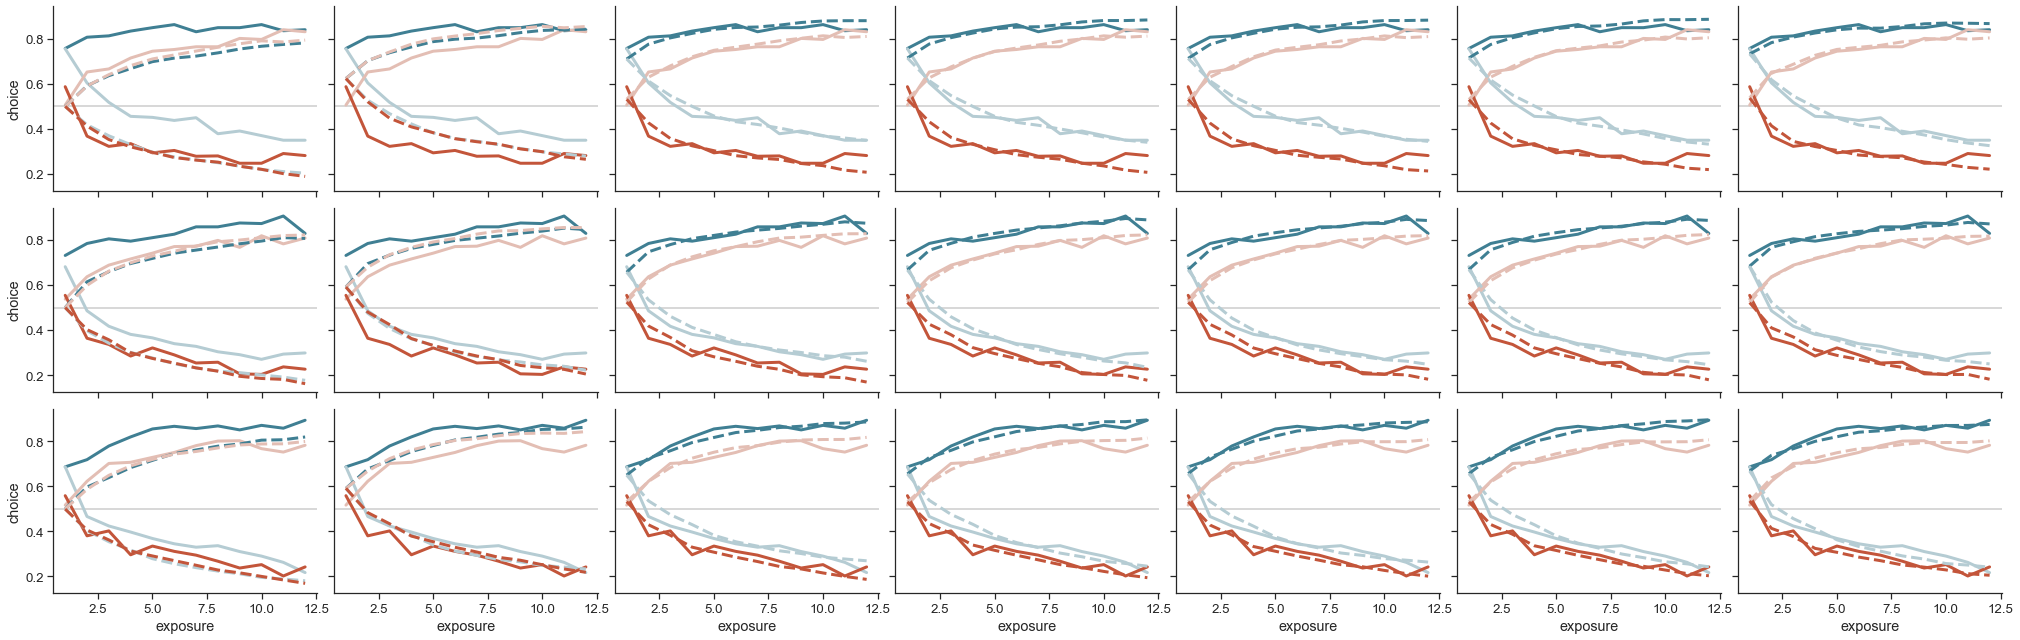

In [9]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*4, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))
            
        ## Plot learning curves.
        sns.lineplot(x='exposure', y='choice', hue='robot', data=ppc, hue_order=order,
                      palette=palette, lw=3, ci=None, ax=axes[i,j])
        sns.lineplot(x='exposure', y='Y_hat', hue='robot', data=ppc, hue_order=order, 
                      palette=palette, lw=3, ci=None, linestyle='--', ax=axes[i,j])

        ## Add trend line.
        axes[i,j].axhline(0.5, color='0.5', alpha=0.4, zorder=-10)
        
        ## Adjust legend.
        axes[i,j].legend_.set_visible(False)
        
sns.despine()
plt.tight_layout()

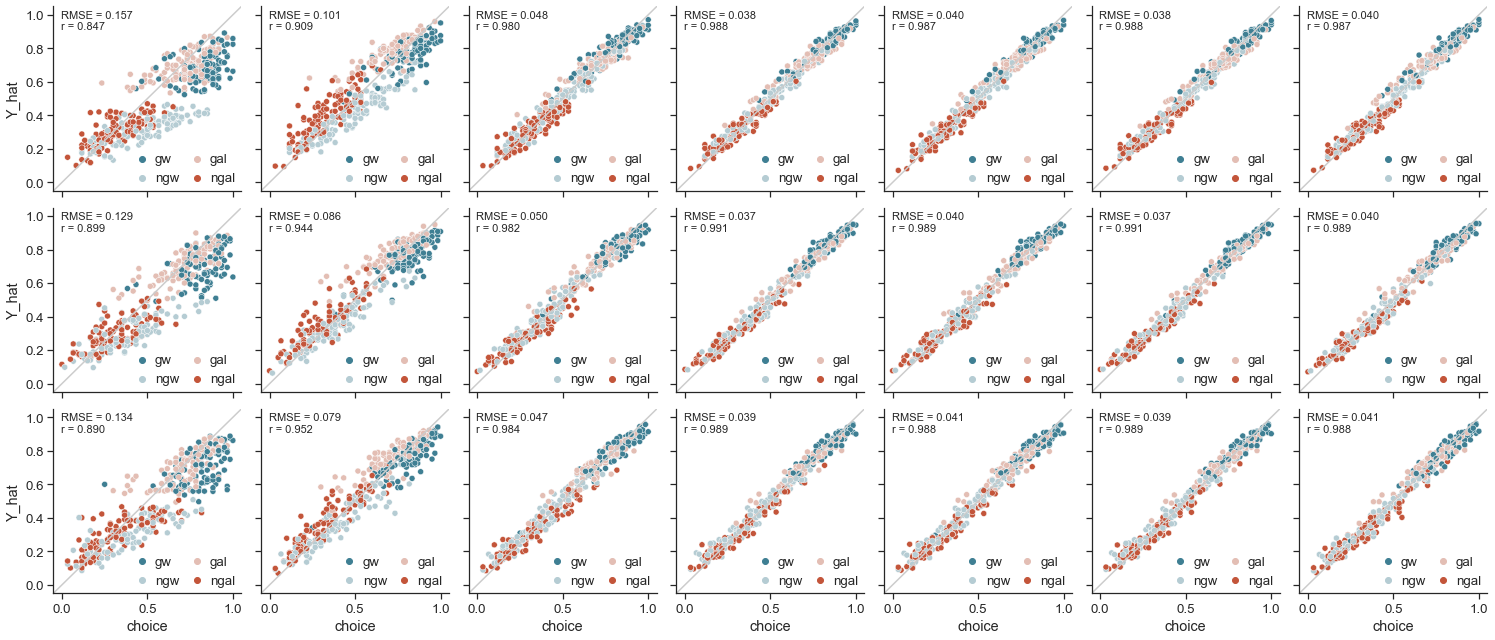

In [10]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*3, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

## Define convenience functions.
RMSE = lambda x: np.sqrt(np.mean(np.square(x)))

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute accuracy by participant / condition.
        gb = ppc.groupby(['subject','robot']).agg({'choice':'mean', 'Y_hat':'mean'}).reset_index()
        
        ## Compute fit statistics.
        rmse = RMSE(gb.choice - gb.Y_hat)
        corr = gb[['choice','Y_hat']].corr().values[0,1]
        
        ## Plot learning curves.
        sns.scatterplot(x='choice', y='Y_hat', hue='robot', data=gb, hue_order=order, 
                        palette=palette, ax=axes[i,j])
        axes[i,j].plot([-1,2], [-1,2], color='0.8')
        
        ## Adjust x-axis.
        axes[i,j].set(xlim=(-0.05,1.05))
        
        ## Adjust y-axis
        axes[i,j].set(ylim=(-0.05,1.05))
        
        ## Adjust legend.
        axes[i,j].legend(loc=4, frameon=False, ncol=2, borderpad=0, handletextpad=0, columnspacing=0.3)
        
        ## Add annotation.
        annot = 'RMSE = %0.3f\nr = %0.3f' %(rmse, corr)
        axes[i,j].annotate(annot, (0,0), (0.04, 0.98), 'axes fraction', ha='left', va='top', fontsize=11)
        
sns.despine()
plt.tight_layout()

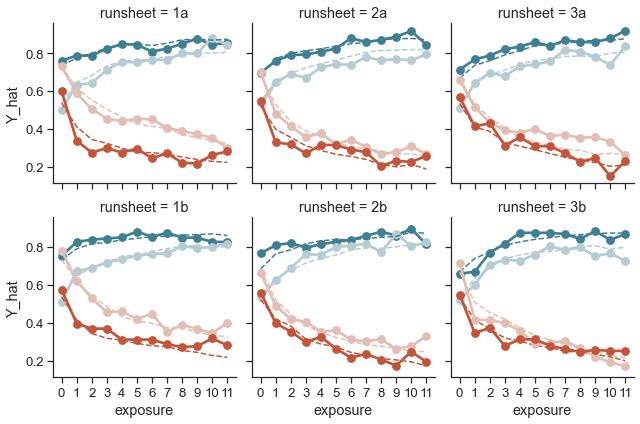

In [11]:
## Define parameters.
sessions = ['s1', 's2', 's3']

## Iteratively load data.
data = concat([read_csv(os.path.join('stan_results', session, 'pgng_m7_ppc.csv'))
               for session in ['s1','s2','s3']])
data['exposure'] -= 1

g = sns.FacetGrid(data, col='runsheet', col_order=['1a','2a','3a','1b','2b','3b'], col_wrap=3)
palette = sns.diverging_palette(220, 20, n=4)

g.map(sns.pointplot, 'exposure', 'choice', 'robot', order=np.arange(12),
      hue_order=['gw','gal','ngw','ngal'], palette=palette, ci=None)
g.map(sns.lineplot, 'exposure', 'Y_hat', 'robot', 
      hue_order=['gw','gal','ngw','ngal'], palette=palette, linestyle='--', ci=None)

## Section 4: Group-level parameters

In [ ]:
## Define parameters.
model = 'pgng_m7'
sessions = ['s1', 's2', 's3', 's4']
cols = ['Mean','StdDev','2.5%','50%','97.5%']

## Iteratively load Stan summaries.
summary = concat([
    read_csv(os.path.join('stan_results', s, f'{model}_summary.tsv'), sep='\t', index_col=0) 
    for s in sessions
])

## Restrict to group-level parameters.
summary = summary.T.filter(regex='theta_mu').T[cols]

## Section 5: Parameter stability

### 5.1 Inverse temperature (positive)

In [12]:
## Define parameters.
model = 'pgng_m7_sh'
sessions = ['s1','s2','s3']

## Iterate over sessions.
for s in sessions:
    
    ## Load samples.
    f = os.path.join('stan_results', s, f'{model}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['b1_mu[1]'].values - samples['b1_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(s, mu, lb, ub, is_credible))

delta (s1): mu = 0.392 [-1.158, 1.860] 
delta (s2): mu = 0.866 [-0.662, 2.593] 
delta (s3): mu = -0.938 [-3.965, 2.065] 


In [17]:
## Define parameters.
model = 'pgng_m7_trt'
pairings = [1,2,3]

## Iterate over sessions.
for p in pairings:
    
    ## Load samples.
    f = os.path.join('stan_results', f'{model}{p}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['b1_mu[1]'].values - samples['b1_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(p, mu, lb, ub, is_credible))

delta (1): mu = -0.456 [-1.396, 0.518] 
delta (2): mu = -1.464 [-2.841, -0.010] **
delta (3): mu = -0.320 [-1.450, 0.768] 


### 5.2 Inverse temperature (negative)

In [13]:
## Define parameters.
model = 'pgng_m7_sh'
sessions = ['s1','s2','s3']

## Iterate over sessions.
for s in sessions:
    
    ## Load samples.
    f = os.path.join('stan_results', s, f'{model}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['b2_mu[1]'].values - samples['b2_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(s, mu, lb, ub, is_credible))

delta (s1): mu = -0.404 [-1.873, 0.875] 
delta (s2): mu = -2.422 [-5.943, 0.791] 
delta (s3): mu = -1.482 [-4.323, 1.380] 


In [18]:
## Define parameters.
model = 'pgng_m7_trt'
pairings = [1,2,3]

## Iterate over sessions.
for p in pairings:
    
    ## Load samples.
    f = os.path.join('stan_results', f'{model}{p}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['b2_mu[1]'].values - samples['b2_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(p, mu, lb, ub, is_credible))

delta (1): mu = -1.366 [-2.903, 0.078] 
delta (2): mu = -2.065 [-4.197, -0.314] **
delta (3): mu = -0.123 [-1.722, 1.260] 


### 5.3 Go bias (positive)

In [14]:
## Define parameters.
model = 'pgng_m7_sh'
sessions = ['s1','s2','s3']

## Iterate over sessions.
for s in sessions:
    
    ## Load samples.
    f = os.path.join('stan_results', s, f'{model}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['b3_mu[1]'].values - samples['b3_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(s, mu, lb, ub, is_credible))

delta (s1): mu = -0.147 [-0.458, 0.180] 
delta (s2): mu = -0.153 [-0.414, 0.104] 
delta (s3): mu = 0.285 [0.029, 0.536] **


In [19]:
## Define parameters.
model = 'pgng_m7_trt'
pairings = [1,2,3]

## Iterate over sessions.
for p in pairings:
    
    ## Load samples.
    f = os.path.join('stan_results', f'{model}{p}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['b3_mu[1]'].values - samples['b3_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(p, mu, lb, ub, is_credible))

delta (1): mu = 0.389 [0.175, 0.611] **
delta (2): mu = 0.501 [0.252, 0.745] **
delta (3): mu = 0.127 [-0.051, 0.310] 


### 5.4 Go bias (negative)

In [15]:
## Define parameters.
model = 'pgng_m7_sh'
sessions = ['s1','s2','s3']

## Iterate over sessions.
for s in sessions:
    
    ## Load samples.
    f = os.path.join('stan_results', s, f'{model}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['b4_mu[1]'].values - samples['b4_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(s, mu, lb, ub, is_credible))

delta (s1): mu = -0.119 [-0.314, 0.074] 
delta (s2): mu = -0.086 [-0.254, 0.094] 
delta (s3): mu = 0.142 [-0.057, 0.341] 


In [20]:
## Define parameters.
model = 'pgng_m7_trt'
pairings = [1,2,3]

## Iterate over sessions.
for p in pairings:
    
    ## Load samples.
    f = os.path.join('stan_results', f'{model}{p}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['b4_mu[1]'].values - samples['b4_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(p, mu, lb, ub, is_credible))

delta (1): mu = 0.102 [-0.030, 0.244] 
delta (2): mu = 0.064 [-0.094, 0.213] 
delta (3): mu = -0.051 [-0.218, 0.101] 


### 5.5 Learning rate (positive)

In [16]:
## Define parameters.
model = 'pgng_m7_sh'
sessions = ['s1','s2','s3']

## Iterate over sessions.
for s in sessions:
    
    ## Load samples.
    f = os.path.join('stan_results', s, f'{model}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['a1_mu[1]'].values - samples['a1_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(s, mu, lb, ub, is_credible))

delta (s1): mu = -0.011 [-0.097, 0.077] 
delta (s2): mu = -0.053 [-0.125, 0.020] 
delta (s3): mu = 0.007 [-0.047, 0.066] 


In [21]:
## Define parameters.
model = 'pgng_m7_trt'
pairings = [1,2,3]

## Iterate over sessions.
for p in pairings:
    
    ## Load samples.
    f = os.path.join('stan_results', f'{model}{p}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['a1_mu[1]'].values - samples['a1_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(p, mu, lb, ub, is_credible))

delta (1): mu = -0.020 [-0.069, 0.028] 
delta (2): mu = 0.034 [-0.035, 0.107] 
delta (3): mu = 0.031 [-0.021, 0.079] 


### 5.6 Learning rate (negative)

In [17]:
## Define parameters.
model = 'pgng_m7_sh'
sessions = ['s1','s2','s3']

## Iterate over sessions.
for s in sessions:
    
    ## Load samples.
    f = os.path.join('stan_results', s, f'{model}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['a2_mu[1]'].values - samples['a2_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(s, mu, lb, ub, is_credible))

delta (s1): mu = 0.098 [0.015, 0.181] **
delta (s2): mu = 0.028 [-0.039, 0.094] 
delta (s3): mu = 0.057 [0.003, 0.111] **


In [22]:
## Define parameters.
model = 'pgng_m7_trt'
pairings = [1,2,3]

## Iterate over sessions.
for p in pairings:
    
    ## Load samples.
    f = os.path.join('stan_results', f'{model}{p}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['a2_mu[1]'].values - samples['a2_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(p, mu, lb, ub, is_credible))

delta (1): mu = 0.111 [0.025, 0.205] **
delta (2): mu = 0.154 [0.068, 0.257] **
delta (3): mu = -0.013 [-0.072, 0.049] 


### 5.7 Lapse rate

In [18]:
## Define parameters.
model = 'pgng_m7_sh'
sessions = ['s1','s2','s3']

## Iterate over sessions.
for s in sessions:
    
    ## Load samples.
    f = os.path.join('stan_results', s, f'{model}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['c1_mu[1]'].values - samples['c1_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(s, mu, lb, ub, is_credible))

delta (s1): mu = -0.001 [-0.036, 0.033] 
delta (s2): mu = 0.004 [-0.023, 0.032] 
delta (s3): mu = 0.033 [0.001, 0.070] **


In [23]:
## Define parameters.
model = 'pgng_m7_trt'
pairings = [1,2,3]

## Iterate over sessions.
for p in pairings:
    
    ## Load samples.
    f = os.path.join('stan_results', f'{model}{p}.tsv.gz')
    samples = read_csv(f, sep='\t', compression='gzip')
    
    ## Compute difference. 
    arr = samples['c1_mu[1]'].values - samples['c1_mu[2]'].values

    ## Summarize & report.
    mu = np.mean(arr)
    lb, ub = hdi(arr, hdi_prob=0.95)
    is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
    print('delta (%s): mu = %0.3f [%0.3f, %0.3f] %s' %(p, mu, lb, ub, is_credible))

delta (1): mu = 0.016 [-0.010, 0.041] 
delta (2): mu = 0.009 [-0.027, 0.047] 
delta (3): mu = -0.001 [-0.029, 0.031] 


## Section 6: Reliability

In [24]:
## Define paramaters.
model = 'pgng_m7'

## Load summary.
reliability = read_csv(os.path.join('stan_results', f'{model}_reliability.csv'))

### 6.1 Split-half reliability

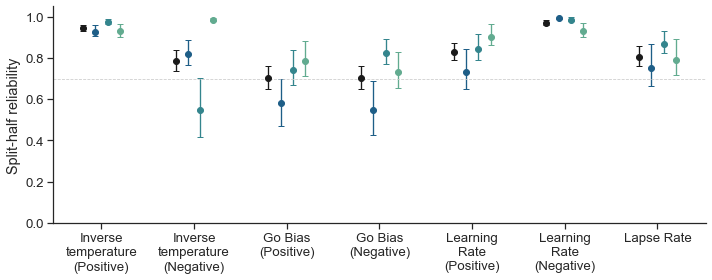

In [70]:
## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(10,4))
palette = np.append('k', sns.color_palette('crest_r', n_colors=3).as_hex())
offsets = np.linspace(-0.2,0.2,4)

for i, (offset, color) in enumerate(zip(offsets, palette)):

    ## Define points.
    y = reliability.query(f'Type == "sh" and Group == {i}').Mean
    x = np.arange(len(y)) + offset
    yerr = np.array([
        reliability.query(f'Type == "sh" and Group == {i}')['97.5%'] - y,
        y - reliability.query(f'Type == "sh" and Group == {i}')['2.5%']
    ])
    
    ## Plot.
    ax.errorbar(x, y, fmt='o', yerr=yerr, color=color, capsize=3, elinewidth=1.33)
    
## Add detail.
ax.axhline(0.7, color='0.8', lw=0.8, linestyle='--')
ax.set(xticks=np.arange(7), ylim=(0,1.05), ylabel='Split-half reliability')
ax.set_xticklabels(['Inverse\ntemperature\n(Positive)','Inverse\ntemperature\n(Negative)',
                    'Go Bias\n(Positive)','Go Bias\n(Negative)','Learning\nRate\n(Positive)',
                    'Learning\nRate\n(Negative)','Lapse Rate'])

sns.despine()
plt.tight_layout()

### 6.2 Test-retest reliability

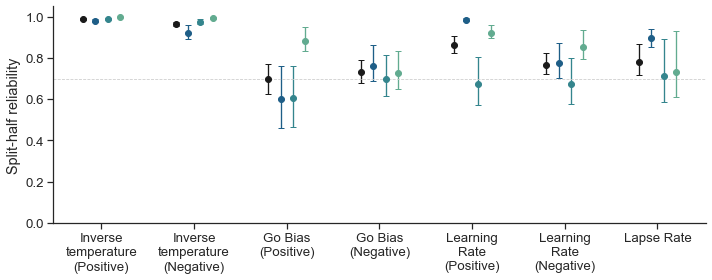

In [71]:
## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(10,4))
palette = np.append('k', sns.color_palette('crest_r', n_colors=3).as_hex())
offsets = np.linspace(-0.2,0.2,4)

for i, (offset, color) in enumerate(zip(offsets, palette)):

    ## Define query.
    query = f'Type == "trt" and Group == {i}'
    
    ## Define points.
    y = reliability.query(query).Mean
    x = np.arange(len(y)) + offset
    yerr = np.array([
        reliability.query(query)['97.5%'] - y,
        y - reliability.query(query)['2.5%']
    ])
    
    ## Plot.
    ax.errorbar(x, y, fmt='o', yerr=yerr, color=color, capsize=3, elinewidth=1.33)
    
## Add detail.
ax.axhline(0.7, color='0.8', lw=0.8, linestyle='--')
ax.set(xticks=np.arange(7), ylim=(0,1.05), ylabel='Split-half reliability')
ax.set_xticklabels(['Inverse\ntemperature\n(Positive)','Inverse\ntemperature\n(Negative)',
                    'Go Bias\n(Positive)','Go Bias\n(Negative)','Learning\nRate\n(Positive)',
                    'Learning\nRate\n(Negative)','Lapse Rate'])

sns.despine()
plt.tight_layout()